In [1]:
import os
from random import randrange
from functools import partial
import torch
from datasets import load_dataset
from transformers import (AutoModelForCausalLM,
AutoTokenizer,
BitsAndBytesConfig,
HfArgumentParser,
Trainer,
TrainingArguments,
DataCollatorForLanguageModeling,
EarlyStoppingCallback,
pipeline,
logging,
set_seed)

import bitsandbytes as bnb
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel, AutoPeftModelForCausalLM
from trl import SFTTrainer

/home/ubuntu/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## BitsandBytes
By using 4-bit transformer language models, we can achieve impressive results while significantly reducing memory and computational requirements.

Hugging Face Transformers (`transformers`) is closely integrated with `bitsandbytes`. The `BitsAndBytesConfig` class from the `transformers` library allows configuring the model quantization method.

In [2]:
def create_bnb_config(load_in_4bit, bnb_4bit_use_double_quant, bnb_4bit_quant_type, bnb_4bit_compute_dtype):
    """
    Configures model quantization method using bitsandbytes to speed up training and inference

    :param load_in_4bit: Load model in 4-bit precision mode
    :param bnb_4bit_use_double_quant: Nested quantization for 4-bit model
    :param bnb_4bit_quant_type: Quantization data type for 4-bit model
    :param bnb_4bit_compute_dtype: Computation data type for 4-bit model
    """

    bnb_config = BitsAndBytesConfig(
        load_in_4bit = load_in_4bit,
        bnb_4bit_use_double_quant = bnb_4bit_use_double_quant,
        bnb_4bit_quant_type = bnb_4bit_quant_type,
        bnb_4bit_compute_dtype = bnb_4bit_compute_dtype,
    )

    return bnb_config

## Loading Hugging Face Model and Tokenizer


In [3]:
def load_model(model_name, bnb_config):
    """
    Loads model and model tokenizer

    :param model_name: Hugging Face model name
    :param bnb_config: Bitsandbytes configuration
    """

    # Get number of GPU device and set maximum memory
    n_gpus = torch.cuda.device_count()
    max_memory = f'{40960}MB'

    # Load model
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config = bnb_config,
        device_map = "auto", # dispatch the model efficiently on the available resources
        max_memory = {i: max_memory for i in range(n_gpus)},
    )

    # Load model tokenizer with the user authentication token
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token = False)

    # Set padding token as EOS token
    tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

## Initializing Transformers and Bitsandbytes Parameters


In [4]:
model_name = "beomi/llama-2-ko-7b"

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
load_in_4bit = True

# Activate nested quantization for 4-bit base models (double quantization)
bnb_4bit_use_double_quant = True

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Compute data type for 4-bit base models
bnb_4bit_compute_dtype = torch.bfloat16

In [5]:
bnb_config = create_bnb_config(load_in_4bit, bnb_4bit_use_double_quant, bnb_4bit_quant_type, bnb_4bit_compute_dtype)

model, tokenizer = load_model(model_name, bnb_config)

Loading checkpoint shards: 100%|██████████| 15/15 [00:17<00:00,  1.19s/it]
/home/ubuntu/myenv/lib/python3.10/site-packages/transformers/models/auto/tokenization_auto.py:748: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


## Loading Dataset

In [6]:
import pandas as pd
control_df = pd.read_csv("./Control_db.csv")
dementia_df = pd.read_csv("./Dementia_db.csv")
test_df = pd.read_csv("./Testing_db.csv")


# Combine the datasets
df = pd.concat([control_df, dementia_df], ignore_index=True)
df = df.sample(frac=1)

In [7]:
# The instruction dataset to use
dataset_name = ["./Control_db.csv","./Dementia_db.csv", ]

# Load dataset
dataset = load_dataset("csv", data_files = dataset_name, split='train')

print(f'Number of prompts: {len(dataset)}')
print(f'Column names are: {dataset.column_names}')

Number of prompts: 108
Column names are: ['Language', 'Data', 'Participant', 'Age', 'Gender', 'Diagnosis', 'Category', 'mmse', 'Filename', 'Transcript']


In [8]:
dataset

Dataset({
    features: ['Language', 'Data', 'Participant', 'Age', 'Gender', 'Diagnosis', 'Category', 'mmse', 'Filename', 'Transcript'],
    num_rows: 108
})

## Creating Prompt Template

In [9]:
def create_prompt_formats(sample, instruction= None):
    """
    Creates a formatted prompt template for a prompt in the instruction dataset

    :param sample: Prompt or sample from the instruction dataset
    """
    label_map = {0: "healthy", 1: "alzheimers"}
    instruction = "The input is a transcription of a patient who could have the alzheimers disease. Based on the transcription respond with 'healthy' or 'alzheimers' according to the patients diagnosis."

    # Initialize static strings for the prompt template
    INTRO_BLURB = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
    INSTRUCTION_KEY = "### Instruction:"
    INPUT_KEY = "Input:"
    RESPONSE_KEY = "### Response:"
    END_KEY = "### End"

    # Combine a prompt with the static strings
    blurb = f"{INTRO_BLURB}"
    instruction = f"{INSTRUCTION_KEY}\n{instruction}"
    input_context = f"{INPUT_KEY}\n{sample['Transcript']}" if sample['Transcript'] else None
    response = f"{RESPONSE_KEY}\n{label_map[sample['Category']]}"
    end = f"{END_KEY}"

    # Create a list of prompt template elements
    parts = [part for part in [blurb, instruction, input_context, response, end] if part]

    # Join prompt template elements into a single string to create the prompt template
    formatted_prompt = "\n\n".join(parts)

    # Store the formatted prompt template in a new key “text"
    sample["text"] = formatted_prompt

    return sample

In [10]:
create_prompt_formats(dataset[randrange(len(dataset))])

{'Language': 'eng',
 'Data': 'Pitt',
 'Participant': 'PAR',
 'Age': 61,
 'Gender': 'female',
 'Diagnosis': 'Control',
 'Category': 0,
 'mmse': 30.0,
 'Filename': 'S033',
 'Transcript': " mhm . well the water's running over on the floor . &uh the chair [: stool] [* s:r] is tilting . the boy is into the cookie jar . and his sister is reaching for a cookie . the mother's drying dishes . &um do you want action or just want anything I see ? okay . mhm .",
 'text': "Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nThe input is a transcription of a patient who could have the alzheimers disease. Based on the transcription respond with 'healthy' or 'alzheimers' according to the patients diagnosis.\n\nInput:\n mhm . well the water's running over on the floor . &uh the chair [: stool] [* s:r] is tilting . the boy is into the cookie jar . and his sister is reaching for a cookie . the mother's drying dishes . &um do you w

## Getting Maximum Sequence Length of the Pre-trained Model

In [11]:
def get_max_length(model):
    """
    Extracts maximum token length from the model configuration

    :param model: Hugging Face model
    """

    # Pull model configuration
    conf = model.config
    # Initialize a "max_length" variable to store maximum sequence length as null
    max_length = None
    # Find maximum sequence length in the model configuration and save it in "max_length" if found
    for length_setting in ["n_positions", "max_position_embeddings", "seq_length"]:
        max_length = getattr(model.config, length_setting, None)
        if max_length:
            print(f"Found max lenth: {max_length}")
            break
        # Set "max_length" to 1024 (default value) if maximum sequence length is not found in the model configuration
        if not max_length:
            max_length = 1024
            print(f"Using default max length: {max_length}")
    return max_length

## Tokenizing Dataset Batch

In [12]:
def preprocess_batch(batch, tokenizer, max_length):
    """
    Tokenizes dataset batch

    :param batch: Dataset batch
    :param tokenizer: Model tokenizer
    :param max_length: Maximum number of tokens to emit from the tokenizer
    """

    return tokenizer(
        batch["text"],
        max_length = max_length,
        truncation = True,
    )

## Preprocessing Dataset

In [13]:
def preprocess_dataset(tokenizer: AutoTokenizer, max_length: int, seed, dataset: str):
    """
    Tokenizes dataset for fine-tuning

    :param tokenizer (AutoTokenizer): Model tokenizer
    :param max_length (int): Maximum number of tokens to emit from the tokenizer
    :param seed: Random seed for reproducibility
    :param dataset (str): Instruction dataset
    """

    # Add prompt to each sample
    print("Preprocessing dataset…")
    dataset = dataset.map(create_prompt_formats)

    # Apply preprocessing to each batch of the dataset & and remove "instruction", "input", "output", and "text" fields
    _preprocessing_function = partial(preprocess_batch, max_length = max_length, tokenizer = tokenizer)
    dataset = dataset.map(
        _preprocessing_function,
        batched = True,
        remove_columns = ['Language', 'Data','Participant','Age','Gender','Diagnosis','Category','mmse','Filename','Transcript','text'],
    )

    # Filter out samples that have "input_ids" exceeding "max_length"
    dataset = dataset.filter(lambda sample: len(sample["input_ids"]) < max_length)

    # Shuffle dataset
    dataset = dataset.shuffle(seed = seed)

    return dataset

In [14]:
# Random seed
seed = 33

max_length = get_max_length(model)
preprocessed_dataset = preprocess_dataset(tokenizer, max_length, seed, dataset)

Using default max length: 1024
Found max lenth: 2048
Preprocessing dataset…


In [15]:
print(preprocessed_dataset)
print(preprocessed_dataset[0])

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 108
})
{'input_ids': [1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29889, 14350, 263, 2933, 393, 7128, 2486, 1614, 2167, 278, 2009, 29889, 13, 13, 2277, 29937, 2799, 4080, 29901, 13, 1576, 1881, 338, 263, 1301, 3395, 310, 263, 16500, 1058, 1033, 505, 278, 394, 29920, 6391, 414, 17135, 29889, 16564, 373, 278, 1301, 3395, 10049, 411, 525, 354, 4298, 29891, 29915, 470, 525, 284, 29920, 6391, 414, 29915, 5034, 304, 278, 22069, 24876, 19263, 29889, 13, 13, 4290, 29901, 13, 20759, 869, 278, 11379, 29915, 29879, 471, 11222, 29898, 29887, 29897, 278, 270, 17006, 7878, 433, 6129, 29879, 763, 896, 2337, 437, 869, 263, 2217, 8023, 29915, 29879, 701, 373, 278, 380, 1507, 6416, 262, 29898, 29887, 29897, 975, 869, 540, 29915, 29879, 1018, 262, 29898, 29887, 29897, 304, 679, 263, 15327, 869, 322, 278, 7826, 29915, 29879, 1018, 262, 29898, 29887, 29897, 304, 1371, 322, 1183, 29915, 29879, 6159, 262, 29898, 29887, 29897, 902, 1

## Creating PEFT Configuration

Fine-tuning pretrained LLMs on downstream datasets results in huge performance gains when compared to using the pretrained LLMs out-of-the-box. However, as models get larger and larger, full fine-tuning becomes infeasible to train on consumer hardware. In addition, storing and deploying fine-tuned models independently for each downstream task becomes very expensive, because fine-tuned models are the same size as the original pretrained model. Parameter-Efficient Fine-tuning (PEFT) approaches are meant to address both problems!

In [16]:
def create_peft_config(r, lora_alpha, target_modules, lora_dropout, bias, task_type):
    """
    Creates Parameter-Efficient Fine-Tuning configuration for the model

    :param r: LoRA attention dimension
    :param lora_alpha: Alpha parameter for LoRA scaling
    :param modules: Names of the modules to apply LoRA to
    :param lora_dropout: Dropout Probability for LoRA layers
    :param bias: Specifies if the bias parameters should be trained
    """
    config = LoraConfig(
        r = r,
        lora_alpha = lora_alpha,
        target_modules = target_modules,
        lora_dropout = lora_dropout,
        bias = bias,
        task_type = task_type,
    )

    return config

## Finding Modules for LoRA Application


In [17]:
def find_all_linear_names(model):
    """
    Find modules to apply LoRA to.

    :param model: PEFT model
    """

    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

        if 'lm_head' in lora_module_names:
            lora_module_names.remove('lm_head')
            print(f"LoRA module names: {list(lora_module_names)}")
    return list(lora_module_names)

## Calculating Trainable Parameters

In [18]:
def print_trainable_parameters(model, use_4bit = False):
    """
    Prints the number of trainable parameters in the model.

    :param model: PEFT model
    """

    trainable_params = 0
    all_param = 0

    for _, param in model.named_parameters():
        num_params = param.numel()
        if num_params == 0 and hasattr(param, "ds_numel"):
            num_params = param.ds_numel
        all_param += num_params
        if param.requires_grad:
            trainable_params += num_params

        if use_4bit:
            trainable_params /= 2

    print(f"All Parameters: {all_param:,d} || Trainable Parameters: {trainable_params:,d} || Trainable Parameters %: {100 * trainable_params / all_param}")

## Fine-tuning the Pre-trained Model

In [19]:
def fine_tune(model,
    tokenizer,
    dataset,
    lora_r,
    lora_alpha,
    lora_dropout,
    bias,
    task_type,
    per_device_train_batch_size,
    gradient_accumulation_steps,
    warmup_steps,
    max_steps,
    learning_rate,
    fp16,
    logging_steps,
    output_dir,
    optim):
    """
    Prepares and fine-tune the pre-trained model.

    :param model: Pre-trained Hugging Face model
    :param tokenizer: Model tokenizer
    :param dataset: Preprocessed training dataset
    """

    # Enable gradient checkpointing to reduce memory usage during fine-tuning
    model.gradient_checkpointing_enable()

    # Prepare the model for training
    model = prepare_model_for_kbit_training(model)

    # Get LoRA module names
    target_modules = find_all_linear_names(model)

    # Create PEFT configuration for these modules and wrap the model to PEFT
    peft_config = create_peft_config(lora_r, lora_alpha, target_modules, lora_dropout, bias, task_type)
    model = get_peft_model(model, peft_config)

    # Print information about the percentage of trainable parameters
    print_trainable_parameters(model)

    # Training parameters
    trainer = Trainer(
        model = model,
        train_dataset = dataset,
        args = TrainingArguments(
            per_device_train_batch_size = per_device_train_batch_size,
            gradient_accumulation_steps = gradient_accumulation_steps,
            warmup_steps = warmup_steps,
            max_steps = max_steps,
            learning_rate = learning_rate,
            fp16 = fp16,
            logging_steps = logging_steps,
            output_dir = output_dir,
            optim = optim,
        ),
        data_collator = DataCollatorForLanguageModeling(tokenizer, mlm = False)
    )

    model.config.use_cache = False

    do_train = True

    # Launch training and log metrics
    print("Training…")

    # if do_train:
    train_result = trainer.train()
    metrics = train_result.metrics
    trainer.log_metrics("train", metrics)
    trainer.save_metrics("train", metrics)
    trainer.save_state()
    print(metrics)

    # Save model
    print("Saving last checkpoint of the model…")
    os.makedirs(output_dir, exist_ok = True)
    trainer.model.save_pretrained(output_dir)

    # Free memory for merging weights
    del model
    del trainer
    torch.cuda.empty_cache()

Initializing QLoRA and TrainingArguments parameters below for training.

In [20]:
################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 16

# Alpha parameter for LoRA scaling
lora_alpha = 64

# Dropout probability for LoRA layers
lora_dropout = 0.1

# Bias
bias = "none"

# Task type
task_type = "CAUSAL_LM"

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Batch size per GPU for training
per_device_train_batch_size = 1

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 4

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Optimizer to use
optim = "paged_adamw_32bit"

# Number of training steps (overrides num_train_epochs)
max_steps = 1000

# Linear warmup steps from 0 to learning_rate
warmup_steps = 2

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = True

# Log every X updates steps
logging_steps = 1

"""Calling the `fine_tune` function below to fine-tune or instruction-tune the pre-trained model on our preprocessed news classification instruction dataset."""

fine_tune(model,
tokenizer,
preprocessed_dataset,
lora_r,
lora_alpha,
lora_dropout,
bias,
task_type,
per_device_train_batch_size,
gradient_accumulation_steps,
warmup_steps,
max_steps,
learning_rate,
fp16,
logging_steps,
output_dir,
optim)

max_steps is given, it will override any value given in num_train_epochs


All Parameters: 3,657,830,400 || Trainable Parameters: 39,976,960 || Trainable Parameters %: 1.0929145320679712
Training…


/home/ubuntu/myenv/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
1,4.203500
2,4.552800
3,4.035700
4,3.669600
5,3.050100
6,2.328900
7,2.592500
8,1.852200
9,2.092400
10,1.605300


/home/ubuntu/myenv/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


***** train metrics *****
  epoch                    =     37.037
  total_flos               = 37753295GF
  train_loss               =     0.1664
  train_runtime            = 2:05:09.30
  train_samples_per_second =      0.533
  train_steps_per_second   =      0.133
{'train_runtime': 7509.3036, 'train_samples_per_second': 0.533, 'train_steps_per_second': 0.133, 'total_flos': 4.053729257703014e+16, 'train_loss': 0.16643435242865234, 'epoch': 37.03703703703704}
Saving last checkpoint of the model…


## Test the model

In [21]:
# Load fine-tuned weights
output_dir = "./results"

model = AutoPeftModelForCausalLM.from_pretrained(output_dir, device_map = "auto", torch_dtype = torch.bfloat16)

Loading checkpoint shards: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


In [22]:
model.eval()
model_name = "beomi/llama-2-ko-7b"

tokenizer = AutoTokenizer.from_pretrained(model_name)

pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    device_map={'':0},
)

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MusicgenMelodyForCausalLM', 'MvpForCausalLM', 'OpenLlam

In [23]:
def create_prompt_test(sample, instruction= None):
    """
    Creates a formatted prompt template for a prompt in the instruction dataset

    :param sample: Prompt or sample from the instruction dataset
    """
    instruction = "The input is a transcription of a patient who could have the alzheimers disease. Based on the transcription respond with 'healthy' or 'alzheimers' according to the patients diagnosis."

    # Initialize static strings for the prompt template
    INTRO_BLURB = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
    INSTRUCTION_KEY = "### Instruction:"
    INPUT_KEY = "Input:"
    RESPONSE_KEY = "### Response:"

    # Combine a prompt with the static strings
    blurb = f"{INTRO_BLURB}"
    instruction = f"{INSTRUCTION_KEY}\n{instruction}"
    input_context = f"{INPUT_KEY}\n{sample['Transcript']}" if sample['Transcript'] else None
    response = f"{RESPONSE_KEY}\n"

    # Create a list of prompt template elements
    parts = [part for part in [blurb, instruction, input_context, response] if part]

    # Join prompt template elements into a single string to create the prompt template
    formatted_prompt = "\n\n".join(parts)

    # Store the formatted prompt template in a new key “text"
    sample["text"] = formatted_prompt

    return sample


In [24]:
# The instruction dataset to use
dataset_name = ["./Testing_db.csv"]

# Load dataset
test_dataset = load_dataset("csv", data_files = dataset_name, split='train')

print(f'Number of prompts: {len(dataset)}')
print(f'Column names are: {dataset.column_names}')

Number of prompts: 108
Column names are: ['Language', 'Data', 'Participant', 'Age', 'Gender', 'Diagnosis', 'Category', 'mmse', 'Filename', 'Transcript']


In [25]:
queries = test_dataset.map(create_prompt_test)['text']

In [35]:
# query = query['text']
sequences = pipeline(
    queries,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=10,
    early_stopping=True,
    # do_sample=True,
)

/home/ubuntu/myenv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:535: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


In [36]:
sequences

[[{'generated_text': "Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nThe input is a transcription of a patient who could have the alzheimers disease. Based on the transcription respond with 'healthy' or 'alzheimers' according to the patients diagnosis.\n\nInput:\n &uh this boy is about to fall off o(f) the stool . the mother is &uh washing dishes and the water's spilling over on. the wind is blowing the curtains . the little girl is laughing at her brother who's taking a cookie. think that's it .\n\n### Response:\nhealthy\n\n### End of input"}],
 [{'generated_text': "Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nThe input is a transcription of a patient who could have the alzheimers disease. Based on the transcription respond with 'healthy' or 'alzheimers' according to the patients diagnosis.\n\nInput:\n &uh a boy with a cookie

In [37]:
def extract_responses(sequences):
    responses = []
    for sequence in sequences:
        for item in sequence:
            # Split the text to find the part after "### Response:\n"
            parts = item['generated_text'].split("### Response:\n")
            if len(parts) > 1:
                # Further split to isolate the response before "\n\n### End"
                response_part = parts[1].split("\n\n### End")[0]
                responses.append(response_part.strip())
    return responses

responses = extract_responses(sequences)
print(responses)


['healthy', 'healthy', 'healthy', 'healthy', 'alzheimers', 'alzheimers', 'alzheimers', 'alzheimers', 'alzheimers', 'alzheimers', 'alzheimers', 'alzheimers', 'healthy', 'alzheimers', 'healthy', 'alzheimers', 'alzheimers', 'healthy', 'healthy', 'alzheimers', 'healthy', 'alzheimers', 'alzheimers', 'healthy', 'alzheimers', 'alzheimers', 'healthy', 'alzheimers', 'alzheimers', 'alzheimers', 'alzheimers', 'alzheimers', 'alzheimers', 'alzheimers', 'alzheimers', 'alzheimers', 'alzheimers', 'healthy', 'alzheimers', 'alzheimers', 'alzheimers', 'healthy', 'healthy', 'alzheimers', 'alzheimers', 'alzheimers', 'alzheimers', 'alzheimers']


In [38]:
label_map = {0: "healthy", 1: "alzheimers"}
maps = [(label_map[label], result) for label, result in zip(test_dataset['Category'], responses)]

In [39]:
def calculate_accuracy(data):
    correct_predictions = sum(1 for actual, predicted in data if actual == predicted)
    total_predictions = len(data)
    accuracy = (correct_predictions / total_predictions) * 100  # accuracy as a percentage
    return correct_predictions, accuracy

In [40]:
calculate_accuracy(maps)

(36, 75.0)

In [41]:
maps

[('healthy', 'healthy'),
 ('healthy', 'healthy'),
 ('alzheimers', 'healthy'),
 ('healthy', 'healthy'),
 ('alzheimers', 'alzheimers'),
 ('alzheimers', 'alzheimers'),
 ('healthy', 'alzheimers'),
 ('alzheimers', 'alzheimers'),
 ('alzheimers', 'alzheimers'),
 ('alzheimers', 'alzheimers'),
 ('healthy', 'alzheimers'),
 ('alzheimers', 'alzheimers'),
 ('healthy', 'healthy'),
 ('alzheimers', 'alzheimers'),
 ('healthy', 'healthy'),
 ('healthy', 'alzheimers'),
 ('alzheimers', 'alzheimers'),
 ('healthy', 'healthy'),
 ('healthy', 'healthy'),
 ('alzheimers', 'alzheimers'),
 ('healthy', 'healthy'),
 ('alzheimers', 'alzheimers'),
 ('alzheimers', 'alzheimers'),
 ('healthy', 'healthy'),
 ('healthy', 'alzheimers'),
 ('alzheimers', 'alzheimers'),
 ('healthy', 'healthy'),
 ('alzheimers', 'alzheimers'),
 ('alzheimers', 'alzheimers'),
 ('alzheimers', 'alzheimers'),
 ('alzheimers', 'alzheimers'),
 ('alzheimers', 'alzheimers'),
 ('alzheimers', 'alzheimers'),
 ('healthy', 'alzheimers'),
 ('alzheimers', 'alzheim

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_accuracy_matrix(data):
    # Convert the list of tuples to a DataFrame
    df = pd.DataFrame(data, columns=['True', 'Predicted'])
    
    # Create a confusion matrix
    confusion_matrix = pd.crosstab(df['True'], df['Predicted'], rownames=['Actual'], colnames=['Predicted'], margins=False)
    
    # Plot the confusion matrix using a heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.savefig('llama_conf.pdf')
    plt.show()

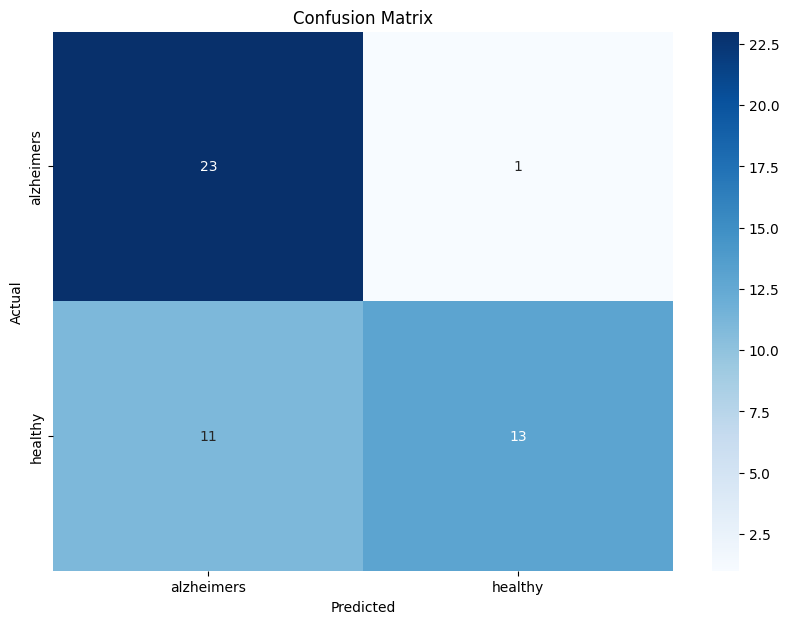

In [43]:
plot_accuracy_matrix(maps)